In [ ]:
torch.finfo(torch.float32).eps

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [2]:
import numpy as np
from functools import partial

import sys
sys.path.append('../../')
import peach as p


import tensorly as tl
from tensorly.decomposition import parafac
from tensorly.kruskal_tensor import kruskal_to_tensor, KruskalTensor
from tensorly.base import unfold

from tensorly.decomposition import quantized_parafac
from tensorly.quantization import quantize_qint

import torch
tl.set_backend('pytorch')

import copy

In [3]:
def get_factors_init(shape, rank, dtype = 'f'):
    if dtype == 'f':
        factors = [torch.randn((i, rank)).type(torch.float32)  for i in shape] 
    elif dtype == 'i':
        factors = [torch.randint(-256, 256, (i, rank)).type(torch.int8) for i in shape]
        
    return factors

## Generate tensor in Kruskal format

In [4]:
numpy_to_struct = {np.float32 : 'f', np.int8 : 'i'}
pytorch_to_struct = {torch.float32 : 'f', torch.int8 : 'i'}

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
rank = 300
shape = (16, 16, 9)

rank_expansion = 1

dtype =  torch.float32
struct_dtype = pytorch_to_struct[dtype]

factors = get_factors_init(shape, rank, dtype = struct_dtype)

for i in range(len(factors)):
    factors[i] = factors[i].repeat(1, rank_expansion)

weights = torch.ones(rank * rank_expansion).type(dtype)
    

krt = KruskalTensor((weights, factors))
t = kruskal_to_tensor(krt).to(device)

tnorm = tl.norm(t.type(torch.float32))
print('||factors||: {}, factors type: {}'.format(tnorm, t.dtype))                                                                       


||factors||: 825.6332397460938, factors type: torch.float32


In [5]:
RANDOM_INIT_STARTS = 10

random_init_starts = RANDOM_INIT_STARTS
inits = ['svd'] + ['random'] * random_init_starts
random_states = [None] + [int(torch.randint(high = 11999, size = (1,))) for _ in range(random_init_starts)]


## ALS

In [30]:
N_ITER_MAX = 50000

QSCHEME = torch.per_channel_affine
DIM = 0 if (shape[0] > rank or shape[1] > rank) else 1


params_als_shared = {'n_iter_max' : N_ITER_MAX,\
                    'tol' : 1e-18,\
                    'normalize_factors' : True,\
                    'svd' : 'numpy_svd',\
                    'verbose' : 0}

params_als = {'orthogonalise' : False,\
              'non_negative' : False,\
              'mask' : None,\
              'return_errors' : False,\
              'stop_criterion' : 'rec_error_decrease'}

params_qint = {'dtype' : torch.qint8,\
               'qscheme' : QSCHEME,\
               'dim' : DIM}

params_qals = {'qmodes' : [0, 1, 2],\
               'return_scale_zeropoint' : True,\
               'stop_criterion' : 'rec_error_decrease'}



In [31]:
rank = rank

run_id = 7
init = inits[run_id]
random_state = random_states[run_id]

# out_als = None
out_als = parafac(t.type(torch.float32), rank,\
              init=init,\
              random_state=random_state,\
              **params_als_shared,\
              **params_als,\
                 )

In [32]:
t_als = kruskal_to_tensor(out_als) 
rec_error_als = tl.norm(t - t_als)

print('||tensor - als_factors||: {}'.format(rec_error_als))

||tensor - als_factors||: 761.3245849609375


In [33]:
for i in range(3):
    print(tl.norm(out_als.factors[0], 2, axis = 0))
    
out_als.weights

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

tensor([ 54093.6172, 158965.0312,  81790.3047,  83904.1797,  39945.5703,
        354158.7812,  70380.8203,  69260.3438,  34719.7891,  10057.7256,
         29761.4082, 123878.2188, 119851.8203,  56869.3164,  26036.2031,
        282181.0312,   8585.0596,  49806.5469, 108293.4375,  50925.9727,
        111832.8672,  14260.6191,  40978.8828, 105224.0859,  36855.5508,
         28522.7871,  36732.5898,  22854.8379,  67397.7734,  63997.3984,
        109245.6328,  18494.9160,  90700.0391,  91785.3750, 164986.8594,
         66721.2422,  43028.9922,  50304.2148,  13145.3779,  15411.0166,
        126044.5391,  98746.8359,  29375.3887,  21416.2305, 127061.3750,
         19309.2578, 102058.7344,  42902.6758,  14679.6973,  56093.6484,
         43329.9805,  39214.4922, 202726.3594, 131725.0312,  42330.4453,
         66052.9688, 147129.0938,  66159.5781,  41001.3516,   6542.1289,
         18728.8164,  37449.5273,  96383.8516, 164784.3750,  49502.8828,
        179838.0000,  74551.7031,  86621.6094,  152

## ALS + post quantization

In [34]:
schemes = \
[(torch.per_tensor_symmetric, None),
 (torch.per_channel_symmetric, 0),
 (torch.per_channel_symmetric, 1),
 (torch.per_tensor_affine, None),
 (torch.per_channel_affine, 0),
 (torch.per_channel_affine, 1)]

In [35]:
for qscheme, dim in schemes[:]:
    params_qint['qscheme'] = qscheme
    params_qint['dim'] = dim
    
    qfactors_post = []
    scales_post = []
    zero_points_post = []
    
    torch.cuda.empty_cache()

    weights_post = copy.deepcopy(out_als.weights)
    
    for i in range(len(out_als.factors)):
        q, s, z = quantize_qint(out_als.factors[i].cpu(),
                                **params_qint,
                                return_scale_zeropoint = True)
        q = q.to(device)
        s = s.to(device)
        z = z.to(device)
        
        qfactors_post.append(q)
        scales_post.append(s)
        zero_points_post.append(z)

        weights_post /=  tl.norm(q, order = 2, axis = 0)

#     print(weights_post)


    qt_post = kruskal_to_tensor(KruskalTensor((weights_post, qfactors_post)))
    rec_error_qpost = tl.norm(t - qt_post)

    print(qscheme, dim)
    print('||tensor - als_factors_quantized||: {}'.format(rec_error_qpost))
    
    
    qt = quantize_qint(t.cpu(),
           **params_qint,
           return_scale_zeropoint = False).to(device)
    print('||tensor - tensor_quantized||: {}\n'.format(tl.norm(t - qt)))

torch.per_tensor_symmetric None
||tensor - als_factors_quantized||: 17715.49609375
||tensor - tensor_quantized||: 6.4526166915893555

torch.per_channel_symmetric 0
||tensor - als_factors_quantized||: 13258.7265625
||tensor - tensor_quantized||: 5.234733581542969

torch.per_channel_symmetric 1
||tensor - als_factors_quantized||: 15332.98828125
||tensor - tensor_quantized||: 5.4516167640686035

torch.per_tensor_affine None
||tensor - als_factors_quantized||: 17446.341796875
||tensor - tensor_quantized||: 6.499914169311523

torch.per_channel_affine 0
||tensor - als_factors_quantized||: 12275.568359375
||tensor - tensor_quantized||: 4.930178165435791

torch.per_channel_affine 1
||tensor - als_factors_quantized||: 10311.3203125
||tensor - tensor_quantized||: 4.973144054412842



In [36]:
zero_points_post, scales_post

([tensor([ 39,  -1,  -2, -14, -18,  40,  21,  27,  -1, -20,  15,  -3, -23,  55,
           47,  32,  16,   0,   4, -13,   3,  12, -14, -49,  10,   2,  19, -18,
           12, -15, -17,  39,  11,  40,  16, -45, -18, -16,  -4, -41,  33, -56,
           43,  38, -27,   2,  30,  -5,  27,  -4,   4,  -9, -52, -11,  22, -63,
            9, -24,  45,  23,  -2,  31,  54,  11, -10,  -3, -19, -10,  10,  23,
          -28, -30,  54, -28, -32,  38,  -9,  -7, -39, -58,  -1, -34,  11,  18,
           18, -67, -17, -50, -48,  44,  24, -17,  -5,  49, -35,  14, -20, -18,
           -5, -18,  -3,  16, -31, -27,  15,   4, -12,  -4, -37, -13,  -3,  14,
           51,  12, -22,  30,  11,  10,  -7,  18,   8, -18,  21,   4,  24,   0,
           30, -47, -10,  29,  48, -17, -13,  59,  35,   1, -40,  -2,   2,  -9,
          -22,  23,  59,  39,  -5,  11, -41,   1, -12, -43,  57,  25,  13,   5,
           20,  -4, -40, -32, -34,  19,  24,   8,  -5,  15,  18, -13,  12,   5,
           -6,  32, -15, -15, -11,  10, 

## QALS

In [37]:
params_qint['qscheme'] = QSCHEME
params_qint['dim'] = DIM
    
qout, qerrors, scales, zero_points = quantized_parafac(t, rank,\
                                                         init=init,\
                                                         random_state=random_state,\
                                                         **params_als_shared,\
                                                         **params_qals,\
                                                         **params_qint)
t_approx_qals = kruskal_to_tensor(KruskalTensor(qout))
rec_error_qals = tl.norm(t - t_approx_qals)

print('||tensor - qals_factors||: {}'.format(rec_error_qals))


||tensor - qals_factors||: 10806.677734375


In [38]:
import matplotlib.pylab as plt

2
4
2


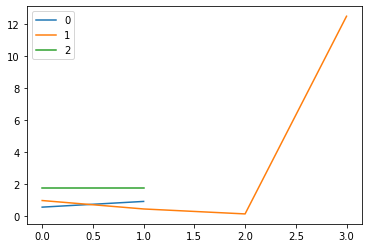

In [39]:
for mode, arr in enumerate(qerrors[:]):
    print(len(arr))
    plt.plot(np.array(arr), label = '{}'.format(mode))
    
plt.legend()

In [40]:
scales[0].shape

torch.Size([300])

In [41]:
for i in range(3):
    print(tl.norm(qout.factors[i], 2, axis = 0))
    
    
print(qout.weights)

tensor([0.9985, 0.9990, 0.9997, 0.9995, 0.9990, 0.9976, 0.9994, 0.9985, 0.9959,
        1.0010, 0.9991, 0.9980, 0.9979, 0.9984, 0.9975, 0.9989, 0.9985, 0.9994,
        0.9993, 0.9990, 0.9991, 0.9987, 1.0006, 0.9991, 0.9988, 0.9982, 0.9997,
        0.9992, 0.9990, 1.0019, 0.9993, 0.9980, 1.0001, 0.9999, 0.9995, 0.9988,
        0.9996, 1.0010, 0.9973, 0.9995, 0.9990, 1.0020, 0.9988, 0.9991, 0.9987,
        0.9969, 0.9982, 0.9987, 0.9979, 0.9977, 0.9992, 1.0007, 1.0003, 1.0012,
        0.9974, 0.9987, 0.9994, 0.9974, 1.0014, 0.9990, 0.9976, 1.0005, 0.9998,
        0.9978, 0.9986, 0.9992, 0.9990, 0.9980, 0.9973, 0.9984, 0.9999, 0.9994,
        0.9971, 1.0007, 1.0003, 0.9998, 0.9983, 0.9984, 0.9983, 1.0002, 1.0004,
        0.9991, 0.9983, 0.9971, 0.9992, 1.0003, 0.9984, 0.9981, 0.9992, 0.9985,
        0.9997, 0.9976, 1.0001, 0.9996, 1.0001, 1.0003, 0.9978, 0.9995, 1.0005,
        1.0009, 1.0013, 0.9972, 0.9983, 0.9974, 0.9970, 0.9981, 1.0006, 0.9989,
        0.9996, 0.9971, 0.9990, 0.9976, 

## For simulated annealing

In [ ]:
def restore_factors(factors_flatten, shapes):
    factors_restored = []
    l = 0
    for shape in shapes:
        dl = np.prod(shape)
        factors_restored.append(torch.tensor(factors_flatten)[l : l + dl].reshape(shape))
        l += dl
    return factors_restored


def norm_error(factors_flatten, shapes, t, weights = None,\
               scales = None, zero_points = None):
    
    factors_restored = restore_factors(factors_flatten, shapes)
    if scales is not None:
        factors_restored = [(factors_restored[i] - zero_points[i]) * scales[i]\
                            for i in range(len(scales))]

    tensor_restored = kruskal_to_tensor(KruskalTensor((weights, factors_restored)))

    norm_error = tl.norm(tensor_restored - t)
  
    global i
    global gnorm
    i += 1
    gnorm = float(norm_error)
    
    return float(norm_error)

## ALS + post quantization + simulated annealing

In [ ]:
qmin=-128
qmax=127
qfactors_post[0]/scales_post[0] + zero_points_post[0]

In [ ]:
scales_post[0].shape

In [ ]:
# qmin = -128
# qmax = 127
qfactors_post_int = [(qfactors_post[i]/scales_post[i] + zero_points_post[i]).cpu() \
                     for i in range(len(qfactors_post))]

shapes = [factor.shape for factor in qfactors_post_int]
factors_flatten_init =  torch.cat([factor.flatten() for factor in qfactors_post_int])
factors_flatten_init = factors_flatten_init.type(torch.int8)


bsa_als = None

# numpy_to_struct = {np.float32 : 'f', np.float64 : 'd',  np.float16 : 'e',\
#                    np.int8 : 'b', np.int16 : 'h', np.int32 : 'i', np.int64 : 'q',\
#                    np.uint8 : 'B', np.uint16 : 'H', np.uint32 : 'I', np.uint64 : 'Q'}


mask = np.zeros(8).astype(bool)
mask[-1:] = True

neighbor_params = {'nb':1, 'mask': mask}
neighbor = p.sa.MaskedBitsNeighbor(**neighbor_params)

i = 0
gnorm = 0
bsa_als = p.BinarySA(partial(norm_error,
                             shapes = shapes,
                             t = t.cpu(),
                             weights = weights_post.cpu(),
                             scales = [s.cpu() for s in scales_post],
                             zero_points = [z.cpu() for z in zero_points_post]
                            ),
                             np.array(factors_flatten_init).astype(np.int8),
                             [(-2**7, 2**7-1)]*len(factors_flatten_init),
                             'i'*len(factors_flatten_init),
                             emax = 1e-10,
                             imax = 10000,
                             T0 = 1,
                             rt = 0.8,
                             neighbor = neighbor
                    )

In [ ]:
# make sense to run several times
for r in range(10000):
    flatten_factors_opt_als, error_als =  bsa_als()
    if r % 100 == 0:
        print('round {}, i = {}, norm_error = {}'.format(r, i, gnorm))
    i = 0
    

In [ ]:
flatten_factors_opt_als, error_als =  bsa_als()
print(gnorm)

## QALS + simulated annealing

In [ ]:
qout_factors_int = [(qout.factors[i].cpu()/scales[i]+zero_points[i]).cpu() for i in range(len(qout.factors))]

shapes = [factor.shape for factor in qout_factors_int]
factors_flatten_init =  torch.cat([factor.flatten() for factor in qout_factors_int])
factors_flatten_init = factors_flatten_init.type(torch.int8)


bsa_qals = None

# numpy_to_struct = {np.float32 : 'f', np.float64 : 'd',  np.float16 : 'e',\
#                    np.int8 : 'b', np.int16 : 'h', np.int32 : 'i', np.int64 : 'q',\
#                    np.uint8 : 'B', np.uint16 : 'H', np.uint32 : 'I', np.uint64 : 'Q'}


mask = np.zeros(8).astype(bool)
mask[-1:] = True

neighbor_params = {'nb':1, 'mask': mask}
neighbor = p.sa.MaskedBitsNeighbor(**neighbor_params)

bsa_qals = p.BinarySA(partial(norm_error,
                             shapes = shapes,
                             t = t.cpu(),
                             weights = weights_post.cpu(),
                             scales = [s.cpu() for s in scales_post],
                             zero_points = [z.cpu() for z in zero_points_post]
                            ),
                             np.array(factors_flatten_init).astype(np.int8),
                             [(-2**7, 2**7-1)]*len(factors_flatten_init),
                             'i'*len(factors_flatten_init),
                             emax = 1e-10,
                             imax = 10000,
                             T0 = 1,
                             rt = 0.8,
                             neighbor = neighbor
                    )

In [ ]:
# make sense to run several times
for r in range(10000):
    flatten_factors_opt_qals, error_qals =  bsa_qals()
    if r % 100 == 0:
        print('round {}, i = {}, norm_error = {}'.format(r, i, gnorm))
    i = 0

In [ ]:
flatten_factors_opt_qals, error_qals =  bsa_qals()
print(gnorm)

In [ ]:
flatten_factors_opt_qals